In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd

In [2]:
f = pd.read_hdf('../h5files/events_anomalydetection.h5')

In [3]:
events_combined = f.T

In [4]:
np.shape(events_combined)


(2101, 1100000)

In [10]:
#Now, let's cluster some jets more efficiently!
leadpT = {}
alljets = {}
for mytype in ['background','signal']:
    leadpT[mytype]=[]
    alljets[mytype]=[]
    for i in range(100000): #len(events_combined)):
        if i%10000==0:
            print(mytype,i)
        issignal = events_combined[i][2100]
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
            continue
        pseudojets_input = np.zeros(len([x for x in events_combined[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
        events_filled = events_combined[i][:np.shape(pseudojets_input)[0]*3].values.reshape(np.shape(pseudojets_input)[0], 3)

        pseudojets_input['pT'] = events_filled[:, 0]
        pseudojets_input['eta'] = events_filled[:, 1]
        pseudojets_input['phi'] = events_filled[:, 2]
        sequence = cluster(pseudojets_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)
        leadpT[mytype] += [jets[0].pt]
        alljets[mytype] += [jets]

background 0
background 10000
background 20000
background 30000
background 40000
background 50000
background 60000
background 70000
background 80000
background 90000
signal 0
signal 10000
signal 20000
signal 30000
signal 40000
signal 50000
signal 60000
signal 70000
signal 80000
signal 90000


In [14]:
print(events_filled)

[[ 3.06938343e+01 -1.56809974e+00  2.29802990e+00]
 [ 6.60844374e+00 -1.56804311e+00  2.28433609e+00]
 [ 7.65378428e+00 -1.57369590e+00  2.30779552e+00]
 [ 2.71937275e+00 -1.59224546e+00  2.27576280e+00]
 [ 1.43836803e+01 -1.54466736e+00  2.27823639e+00]
 [ 9.66174545e+01 -1.55674672e+00  2.30737805e+00]
 [ 1.75336342e+01 -1.53653920e+00  2.31111193e+00]
 [ 6.15663815e+00 -1.54820395e+00  2.44173527e+00]
 [ 3.88601303e+00 -1.47499990e+00  2.24654198e+00]
 [ 2.74536395e+00 -1.44486558e+00  2.29039073e+00]
 [ 3.11199903e+00 -1.46856475e+00  2.37929583e+00]
 [ 5.15207148e+00 -1.41187465e+00  2.32968545e+00]
 [ 1.03353348e+01 -1.44903326e+00  2.36326814e+00]
 [ 2.31997414e+01 -1.44521081e+00  2.35418153e+00]
 [ 2.60068115e+02 -1.44390535e+00  2.35169315e+00]
 [ 8.93380508e+01 -1.44189227e+00  2.35457397e+00]
 [ 1.36285782e+02 -1.44130826e+00  2.34845638e+00]
 [ 2.09320087e+01 -1.45856202e+00  2.35576439e+00]
 [ 1.84150867e+01 -1.44990718e+00  2.36180639e+00]
 [ 1.56833282e+02 -1.44040608e+

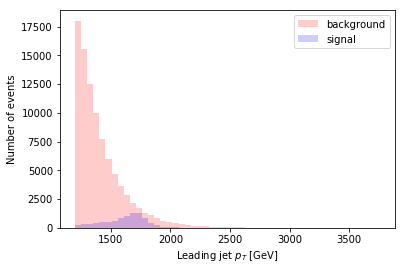

In [11]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(leadpT['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("leadjetpt.pdf")

In [12]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(alljets[mytype])):
        E = alljets[mytype][k][0].e+alljets[mytype][k][1].e
        px = alljets[mytype][k][0].px+alljets[mytype][k][1].px
        py = alljets[mytype][k][0].py+alljets[mytype][k][1].py
        pz = alljets[mytype][k][0].pz+alljets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]


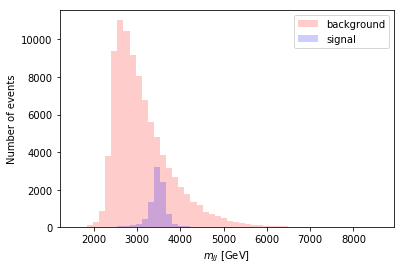

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("mjj.pdf")